# RAMSAR Water, wet vegetation and fractional cover polygon drill stack plot

| Authors:  | Bex Dunn|
|----------|----------------|
| Created: | Jan 7, 2019 |
| Last edited: | March 15, 2019 |

**Requirements:**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

__Background:__ Data from the [Landsat](https://landsat.usgs.gov/about-landsat) 5,7 and 8 satellite missions are accessible through [Digital Earth Australia](http://www.ga.gov.au/about/projects/geographic/digital-earth-australia) (DEA). The code snippets in this notebook will let you retrieve and plot the [Fractional Cover](https://d28rz98at9flks.cloudfront.net/79676/Fractional_Cover_FC25_v1_5.PDF) (FC25) data stored in DEA.

__What does this notebook do?:__ This notebook takes a supplied shapefile of a polygon and queries the datacube for WOfS, Fractional Cover and NBART. It calculates thresholded tasselled cap wetness. The results are plotted against each other as a stacked plot for assessing change in wetlands or land cover. 
    
__How to use this notebook:__

A basic understanding of any programming language is desirable but one doesn't have to be an expert Python programmer to manipulate the code to get and display the data.This doc applies to the following Landsat satellites, Fractional Cover bands and the WOfS dataset:

- Landsat 5
- Landsat 7
- Landsat 8
- PV - Photosythetic vegetation
- NPV - Non-Photosythetic vegetation
- BS - Bare Soil
- WOfS Feature Layers (WOFLs)




__Future Work:__ 
- do this by max extent of wetness
- add rainfall for context
- update code to include potential terrain shadow/low solar angle in wofs - this is to fix the low solar angle issues
        

### import modules


In [11]:
import csv
import multiprocessing as mp

#$#$#$#$#$

import datacube
import datetime
import fiona
import geopandas as gpd
from math import ceil
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import time
import xarray as xr

#keep the plotting modules in here as we want to output the stackplots to *.jpg
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from datacube.storage import masking
from datacube.utils import geometry

#append path to dea notebooks scripts to the system so we can access it
sys.path.append('/g/data/r78/rjd547/jupyter_notebooks/dea-notebooks/10_Scripts')
import DEADataHandling, DEAPlotting, TasseledCapTools

# setup the datacube 
dc = datacube.Datacube(app='asset drill')

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def get_RAMSAR_polyName(shapefile):
    ''' function designed specifically for the RAMSAR wetlands australia shapefile. Takes the shapefile and extracts
    the ramsar name, wetland name and objectID from the ESRI shapefile format and turns it into a useful string for our output.
    :Inputs: shapefile with RAMSAR_NAM, WETLAND_NA, and OBJECTID as properties. 
    Author: Bex Dunn Last Edited: March 2019'''
    # get the ramsar name from the shapes 
    RAMSAR_NAME = '_'.join(shapefile['properties']['RAMSAR_NAM'].split(' '))
    WETLAND_NAME = '_'.join(shapefile['properties']['WETLAND_NA'].split(' '))
    STATE = '_'.join(shapefile['properties']['STATE'].split(' ')) 
    ID = shapefile['id']
    polyName = f'{RAMSAR_NAME}-{WETLAND_NAME}-{STATE}-{ID}'
    print(f'processing polygon {polyName}')
    return(polyName)

In [7]:
def get_masked_ls578_data(query, geom):
    '''create a function that takes in the masked proportion, query and geometry and returns the fully masked surface reflectance data'''
    ## Set up datasets
    #set cloudmasking threshold and load landsat nbart data
    landsat_masked_prop = 0.90
    ls578_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart',
            masked_prop=landsat_masked_prop)

    ### mask the data with our original polygon to remove extra data 

    data = ls578_ds
    mask = rasterio.features.geometry_mask([geom.to_crs(data.geobox.crs)for geoms in [geom]],
                                               out_shape=data.geobox.shape,
                                               transform=data.geobox.affine,
                                               all_touched=False,
                                               invert=False)

    #for some reason xarray is not playing nicely with our old masking function
    mask_xr = xr.DataArray(mask, dims = ('y','x'))
    ls578_ds = data.where(mask_xr==False)
    return ls578_ds, mask_xr

### Munging in progress


In [10]:
first_geometry = lilshape['geometry']
polyName = get_RAMSAR_polyName(lilshape)
geom = geometry.Geometry(first_geometry, crs=crs)
query = {'geopolygon': geom}# this should run for all time, if there is no time set?

#load and mask data. selecting data with more than 90% clear for the geobox around the polygon... #FIXME
ls578_ds, mask_xr= get_masked_ls578_data(query,geom)

print('run tasselled cap transform')
#transform the nbart into tci
tci = TasseledCapTools.thresholded_tasseled_cap(ls578_ds,wetness_threshold=-350, drop=True , drop_tc_bands=True)

### create a masked version of the extent of overthreshold wetness

#select only finite values (over threshold values)
tcw = xr.ufuncs.isfinite(tci.wetness_thresholded)

# #reapply the polygon mask
tcw = tcw.where(mask_xr==False)

### load wofls and select only wet pixels
print('load wofls')
#load wofs
wofls = dc.load(product = 'wofs_albers', like=ls578_ds)

#only get wet obs
wetwofl = masking.make_mask(wofls, wet=True)

#match the wofs observations to the nbart
wetwofl=wetwofl.where(wofls.time==ls578_ds.time)

### mask the wofs obs

#mask the wofs obs with the polygon mask
wetwofl = wetwofl.where(mask_xr==False)

### load in fractional cover data
print('load fractional cover data')
#load the data according to our query
#choose a mask proportion to look for a clear timestep
fc_ds = DEADataHandling.load_clearlandsat(dc, query,product='fc',masked_prop=0.90)

### mask FC with polygon

fc_ds = fc_ds.where(mask_xr==False)

### mask FC with wetness

fc_ds_noTCW=fc_ds.where(tcw==False)

### Calculate number of pixels in area of interest

#number of pixels in area of interest
pixels = (mask_xr==0).sum(dim=['x','y'])

mask_xr==0
mask_xr.count(dim=['x','y'])

#count number of wofs pixels
wofs_pixels = wetwofl.water.sum(dim=['x','y'])

#count percentage of area of wofs
wofs_area_percent = (wofs_pixels/pixels)*100

#count number of tcw pixels
tcw_pixel_count = tcw.sum(dim=['x','y'])

#calculate percentage area wet
tcw_area_percent = (tcw_pixel_count/pixels)*100

#calculate wet not wofs
tcw_less_wofs = tcw_area_percent-wofs_area_percent

### Calculate the dominant fraction for each pixel in Fractional Cover

#drop data percentage and Unmixing Error
fc_tester = fc_ds_noTCW.drop(['data_perc','UE'])

#following robbi's advice, cast the dataset to a dataarray
maxFC = fc_tester.to_array(dim='variable', name='maxFC')

#turn FC array into integer only as nanargmax doesn't seem to handle floats the way we want it to
FC_int = maxFC.astype('int8')

#use numpy.nanargmax to get the index of the maximum value along the variable dimension
#BSPVNPV=np.nanargmax(FC_int, axis=0)
BSPVNPV=FC_int.argmax(dim='variable')

FC_mask=xr.ufuncs.isfinite(maxFC).all(dim='variable')

# #re-mask with nans to remove no-data
BSPVNPV=BSPVNPV.where(FC_mask)


FC_dominant = xr.Dataset({
    'BS': (BSPVNPV==0).where(FC_mask),
    'PV': (BSPVNPV==1).where(FC_mask),
    'NPV': (BSPVNPV==2).where(FC_mask),
})

FC_count = FC_dominant.sum(dim=['x','y'])

#Fractional cover pixel count method
#Get number of FC pixels, divide by total number of pixels per polygon

Bare_soil_percent=(FC_count.BS/pixels)*100

Photosynthetic_veg_percent=(FC_count.PV/pixels)*100

NonPhotosynthetic_veg_percent=(FC_count.NPV/pixels)*100

NoData = 100 - wofs_area_percent- tcw_less_wofs - Photosynthetic_veg_percent - NonPhotosynthetic_veg_percent - Bare_soil_percent

#set up color palette
pal = [sns.xkcd_rgb["grey"],
       sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]]       
#try and figure out what the error is on one of the plots
#make a stacked area plot
plt.clf()
plt.figure(figsize = (26,6))
plt.stackplot(wofs_area_percent.time.values, 
              NoData,
              wofs_area_percent, 
              tcw_less_wofs, 
              Photosynthetic_veg_percent, 
              NonPhotosynthetic_veg_percent,
              Bare_soil_percent,
              labels=['cloud',
                      'open water',
                      'wet',
                      'PV',
                      'NPV',
                      'BS',
                     ], colors=pal, alpha = 0.6)

plt.title(f'Percentage of area WOfS, Wetness, Fractional Cover for {polyName}')


#set date ticks every year

years = mdates.YearLocator(1)
yearsFmt = mdates.DateFormatter('%Y')

#set axis limits to the min and max
plt.axis(xmin = wofs_area_percent.time[0].data, xmax = wofs_area_percent.time[-1].data, ymin = 0, ymax = 100)
ax = plt.gca()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
#add a legend and a tight plot box
plt.legend(loc='lower right')
#plt.tight_layout()

#create rectangle borders for no-data times (SLC-off only)
LS5_8_gap_start = datetime(2011,11,1)
LS5_8_gap_end = datetime(2013,4,1)

# convert to matplotlib date representation
gap_start = mdates.date2num(LS5_8_gap_start)
gap_end = mdates.date2num(LS5_8_gap_end)
gap = gap_end - gap_start

#set up rectangle
slc_rectangle= Rectangle((gap_start,0), gap, 100,alpha = 0.5, facecolor=sns.xkcd_rgb['white'],
             edgecolor=sns.xkcd_rgb['white'], hatch="////",linewidth=2)
ax.add_patch(slc_rectangle)


#save the figure
plt.savefig(f'{Output_dir}{polyName}.png')#, transparent=True)
plt.show()
print(f'plot created for {polyName}')

#make a new dataframe using the data from the xarray of wofs area for the polygon

### start setup of dataframe by adding only one dataset
WOFS_df = pd.DataFrame(data=wofs_area_percent.data, index=wofs_area_percent.time.values,columns=['wofs_area_percent'])

#add data into pandas dataframe for export
WOFS_df['tcw_area_percent']=tcw_less_wofs.data
WOFS_df['PV_percent']=Photosynthetic_veg_percent.data
WOFS_df['NPV_percent']=NonPhotosynthetic_veg_percent.data
WOFS_df['BS_percent']=Bare_soil_percent.data
WOFS_df['Cloud_percent']=NoData.data

#call the composite dataframe something sensible, like PolyDrill
PolyDrill_df = WOFS_df.round(2)

#save the csv of the output data used to create the stacked plot for the polygon drill
PolyDrill_df.to_csv(f'{Output_dir}{polyName}.csv')

NameError: name 'lilshape' is not defined

### Set up polygon

In [74]:
#change the path here if you want a different polygon
### Set up polygon
poly_path='/g/data/r78/rjd547/WA_NRM_wetlands/Ramsar and surrounds.shp' 
print(f'Shape file is {poly_path}')

global Output_dir
Output_dir = '/g/data/r78/rjd547/Ramsar_Wetlands/Ramsar_Outputs_1/'

Shape file is /g/data/r78/rjd547/WA_NRM_wetlands/Ramsar and surrounds.shp


In [75]:
#open the polygon
with fiona.open(poly_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        #polyName = get_RAMSAR_polyName(shapes)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

<Figure size 432x288 with 0 Axes>

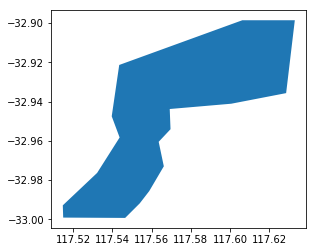

In [76]:
#plot polygon to check it looks ok
plt.clf()
shape_plot = gpd.read_file(poly_path)
shape_plot.plot()
plt.show()

### Set up query

In [77]:
query = {'geopolygon': geom,
         #'time': ('2016-01-01', '2018-06-30')
         #'time': ('2007-01-01', '2007-06-30')
         #'time': ('2013-01-01', '2019-01-01')
         }

## Set up datasets

### set cloudmasking threshold and load landsat nbart data

### mask the data with our original polygon to remove extra data 

In [78]:
#load and mask data. selecting data with more than 90% clear for the geobox around the polygon... #FIXME
ls578_ds, mask_xr= get_masked_ls578_data(query,geom)

Loading ls5
    Loading 170 filtered ls5 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Loading 36 filtered ls7 timesteps
Loading ls8
    Loading 67 filtered ls8 timesteps
Combining and sorting ls5, ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [79]:
#transform the nbart into tci
tci = TasseledCapTools.thresholded_tasseled_cap(ls578_ds,wetness_threshold=-350, drop=True , drop_tc_bands=True)

### create a masked version of the extent of overthreshold wetness

In [80]:
#select only finite values (over threshold values)
tcw = xr.ufuncs.isfinite(tci.wetness_thresholded)

In [81]:
# #reapply the polygon mask
tcw = tcw.where(mask_xr==False)

### load wofls and select only wet pixels

In [82]:
#load wofs
wofls = dc.load(product = 'wofs_albers', like=ls578_ds)

In [83]:
#only get wet obs
wetwofl = masking.make_mask(wofls, wet=True)

In [84]:
#match the wofs observations to the nbart
wetwofl=wetwofl.where(wofls.time==ls578_ds.time)

### mask the wofs obs

In [85]:
#mask the wofs obs with the polygon mask
wetwofl = wetwofl.where(mask_xr==False)

### load in fractional cover data

In [86]:
#load the data according to our query
#choose a mask proportion to look for a clear timestep
fc_ds = DEADataHandling.load_clearlandsat(dc, query,product='fc',masked_prop=0.90)

Loading ls5
    Loading 170 filtered ls5 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Loading 36 filtered ls7 timesteps
Loading ls8
    Loading 67 filtered ls8 timesteps
Combining and sorting ls5, ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


### mask FC with polygon

In [87]:
fc_ds = fc_ds.where(mask_xr==False)

### mask FC with wetness

In [88]:
fc_ds_noTCW=fc_ds.where(tcw==False)
#match the fractional cover time stamps to the wofs time stamps
fc_ds_noTCW=fc_ds_noTCW.where(fc_ds_noTCW.time==wofls.time)

In [89]:
#set scene to plot
scene =2

<Figure size 432x288 with 0 Axes>

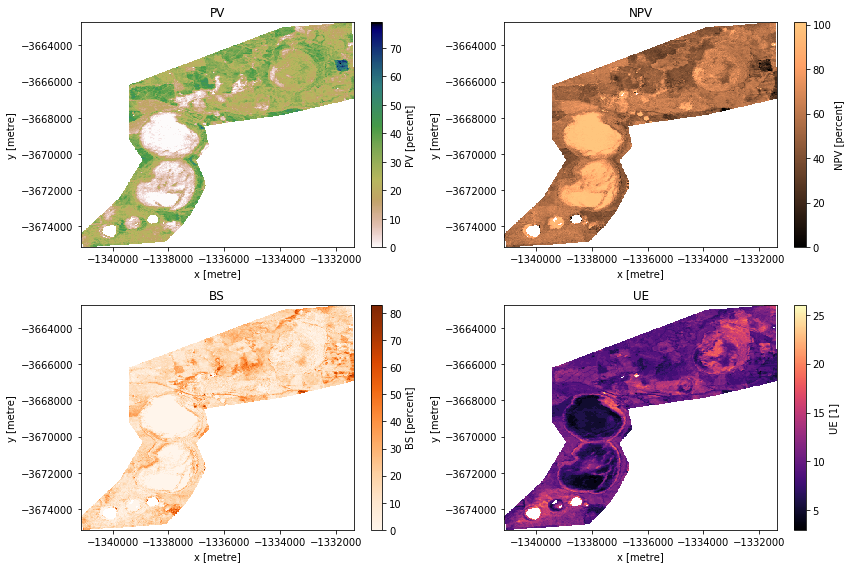

In [90]:
#set up our images on a grid using gridspec
plt.clf()
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,2) # set up a 2 x 2 grid of 4 images for better presentation

ax1=plt.subplot(gs[0,0])
fc_ds_noTCW.PV.isel(time=scene).plot(cmap='gist_earth_r')
ax1.set_title('PV')

ax2=plt.subplot(gs[1,0])
fc_ds_noTCW.BS.isel(time=scene).plot(cmap='Oranges')
ax2.set_title('BS')

ax3=plt.subplot(gs[0,1])
fc_ds_noTCW.NPV.isel(time=scene).plot(cmap='copper')
ax3.set_title('NPV')

ax4=plt.subplot(gs[1,1])
fc_ds_noTCW.UE.isel(time=scene).plot(cmap='magma')
ax4.set_title('UE')

plt.tight_layout()
plt.show()

### Calculate number of pixels in area of interest

In [91]:
#number of pixels in area of interest
pixels = (mask_xr==0).sum(dim=['x','y'])

In [92]:
mask_xr==0
mask_xr.count(dim=['x','y'])

<xarray.DataArray ()>
array(194824)

In [93]:
#count number of wofs pixels
wofs_pixels = wetwofl.water.sum(dim=['x','y'])

#count percentage of area of wofs
wofs_area_percent = (wofs_pixels/pixels)*100

#count number of tcw pixels
tcw_pixel_count = tcw.sum(dim=['x','y'])

#calculate percentage area wet
tcw_area_percent = (tcw_pixel_count/pixels)*100

#calculate wet not wofs
tcw_less_wofs = tcw_area_percent-wofs_area_percent

### Calculate the dominant fraction for each pixel in Fractional Cover

In [94]:
#drop data percentage and Unmixing Error
fc_tester = fc_ds_noTCW.drop(['data_perc','UE'])

#following robbi's advice, cast the dataset to a dataarray
maxFC = fc_tester.to_array(dim='variable', name='maxFC')

#turn FC array into integer only as nanargmax doesn't seem to handle floats the way we want it to
FC_int = maxFC.astype('int8')

#use numpy.nanargmax to get the index of the maximum value along the variable dimension
#BSPVNPV=np.nanargmax(FC_int, axis=0)
BSPVNPV=FC_int.argmax(dim='variable')

FC_mask=xr.ufuncs.isfinite(maxFC).all(dim='variable')

# #re-mask with nans to remove no-data
BSPVNPV=BSPVNPV.where(FC_mask)

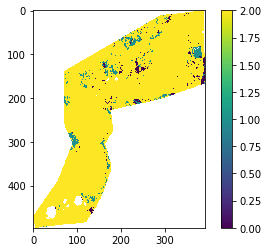

In [95]:
#plot the results to check they look roughly like what we are expecting
plt.clf()
plt.imshow(BSPVNPV[2])
plt.colorbar()

In [96]:
FC_dominant = xr.Dataset({
    'BS': (BSPVNPV==0).where(FC_mask),
    'PV': (BSPVNPV==1).where(FC_mask),
    'NPV': (BSPVNPV==2).where(FC_mask),
})

In [97]:
FC_count = FC_dominant.sum(dim=['x','y'])

In [98]:
#Fractional cover pixel count method
#Get number of FC pixels, divide by total number of pixels per polygon

Bare_soil_percent=(FC_count.BS/pixels)*100

Photosynthetic_veg_percent=(FC_count.PV/pixels)*100

NonPhotosynthetic_veg_percent=(FC_count.NPV/pixels)*100

NoData = 100 - wofs_area_percent- tcw_less_wofs - Photosynthetic_veg_percent - NonPhotosynthetic_veg_percent - Bare_soil_percent

In [99]:
len(wofs_area_percent.time.values)

273

In [100]:
len(NoData)

273

In [101]:
len(wofs_area_percent)

273

In [102]:
len(Photosynthetic_veg_percent)

273

In [103]:
len(NonPhotosynthetic_veg_percent)

273

In [104]:
len(tcw_less_wofs)

273

<Figure size 432x288 with 0 Axes>

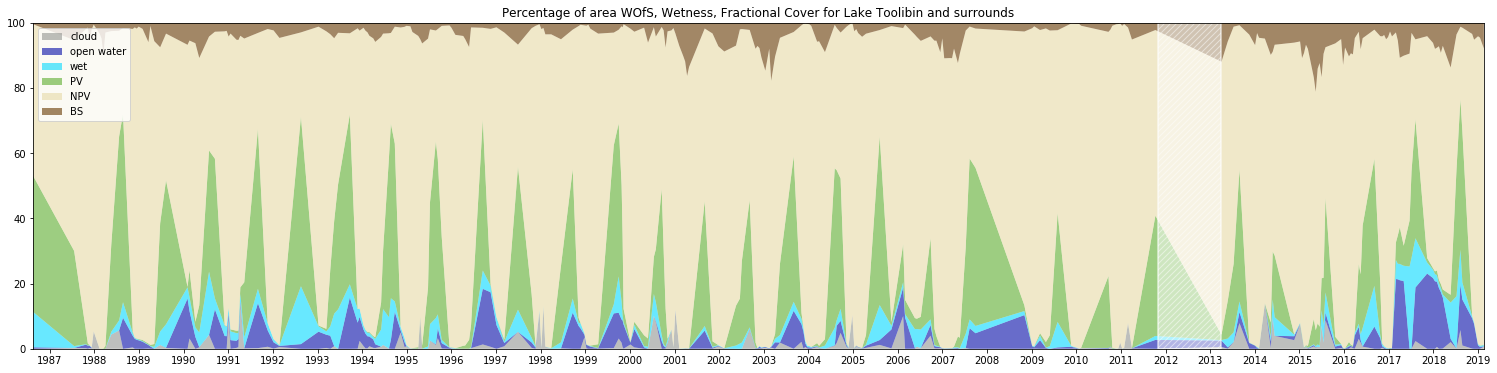

plot created for Lake Toolibin and surrounds
wrote output data to file /g/data/r78/rjd547/Ramsar_Wetlands/Ramsar_Outputs_1/Lake Toolibin and surrounds.csv


In [106]:
#set up color palette
pal = [sns.xkcd_rgb["grey"],
       sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]]       
#try and figure out what the error is on one of the plots
#make a stacked area plot
plt.clf()
plt.figure(figsize = (26,6))
plt.stackplot(wofs_area_percent.time.values, 
              NoData,
              wofs_area_percent, 
              tcw_less_wofs, 
              Photosynthetic_veg_percent, 
              NonPhotosynthetic_veg_percent,
              Bare_soil_percent,
              labels=['cloud',
                      'open water',
                      'wet',
                      'PV',
                      'NPV',
                      'BS',
                     ], colors=pal, alpha = 0.6)
polyName = 'Lake Toolibin and surrounds'
plt.title(f'Percentage of area WOfS, Wetness, Fractional Cover for {polyName}')


#set date ticks every year

years = mdates.YearLocator(1)
yearsFmt = mdates.DateFormatter('%Y')

#set axis limits to the min and max
plt.axis(xmin = wofs_area_percent.time[0].data, xmax = wofs_area_percent.time[-1].data, ymin = 0, ymax = 100)
ax = plt.gca()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
#add a legend and a tight plot box
plt.legend(loc='upper left')
#plt.tight_layout()

#create rectangle borders for no-data times (SLC-off only)
LS5_8_gap_start = datetime(2011,11,1)
LS5_8_gap_end = datetime(2013,4,1)

# convert to matplotlib date representation
gap_start = mdates.date2num(LS5_8_gap_start)
gap_end = mdates.date2num(LS5_8_gap_end)
gap = gap_end - gap_start

#set up rectangle
slc_rectangle= Rectangle((gap_start,0), gap, 100,alpha = 0.5, facecolor=sns.xkcd_rgb['white'],
             edgecolor=sns.xkcd_rgb['white'], hatch="////",linewidth=2)
ax.add_patch(slc_rectangle)


#save the figure
plt.savefig(f'{Output_dir}{polyName}.png')#, transparent=True)
plt.show()
print(f'plot created for {polyName}')

#make a new dataframe using the data from the xarray of wofs area for the polygon

### start setup of dataframe by adding only one dataset
WOFS_df = pd.DataFrame(data=wofs_area_percent.data, index=wofs_area_percent.time.values,columns=['wofs_area_percent'])

#add data into pandas dataframe for export
WOFS_df['tcw_area_percent']=tcw_less_wofs.data
WOFS_df['PV_percent']=Photosynthetic_veg_percent.data
WOFS_df['NPV_percent']=NonPhotosynthetic_veg_percent.data
WOFS_df['BS_percent']=Bare_soil_percent.data
WOFS_df['Cloud_percent']=NoData.data

#call the composite dataframe something sensible, like PolyDrill
PolyDrill_df = WOFS_df.round(2)

#save the csv of the output data used to create the stacked plot for the polygon drill
PolyDrill_df.to_csv(f'{Output_dir}{polyName}.csv')
print(f'wrote output data to file {Output_dir}{polyName}.csv')